In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
from utils.visualizer import Visualizer
from IPython.display import SVG, display
from sklearn.metrics import precision_recall_curve

import numpy as np
import matplotlib.pyplot as plt

import os
import time
import pickle
import sklearn
import lasagne
import itertools

plt.style.use('ggplot')

%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [ ]:
def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt].astype(np.float32), targets[excerpt].astype(np.float32)


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2].astype(np.float32), y_val[:2].astype(np.float32))
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()

# Build the dataset

In [ ]:
dataset = np.load('../data/artificial_dataset1.npy')
targets = np.load('../data/artificial_dataset1_targets.npy')

# Build the network

In [7]:
from models.vgg16 import VGG16

In [9]:
vgg = VGG16((1, 350, 500)

In [11]:
list(reversed([10.0 * 1e1**-i for i in range(1, 7)]))

[9.999999999999999e-06, 0.0001, 0.001, 0.01, 0.1, 1.0]

In [12]:
X_y = train_test_split(dataset.reshape(-1, 1, 350, 500), targets.reshape(-1, 1, 350, 500))

<IPython.core.display.Javascript object>


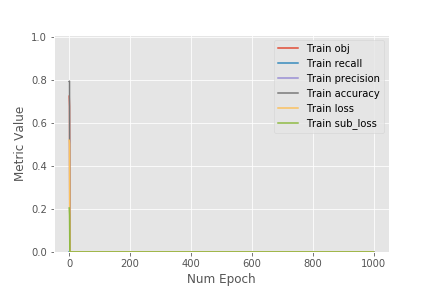

<IPython.core.display.Javascript object>


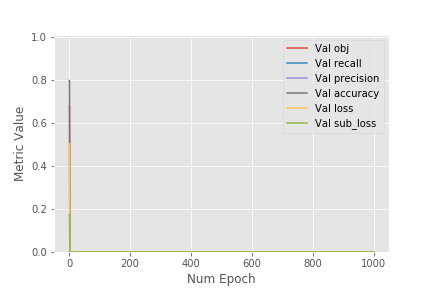

<IPython.core.display.Javascript object>


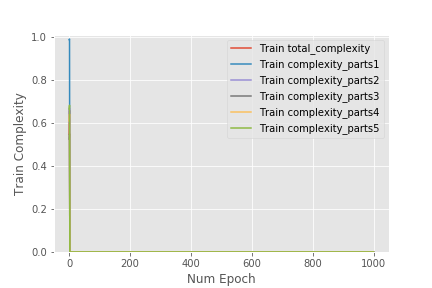

<IPython.core.display.Javascript object>


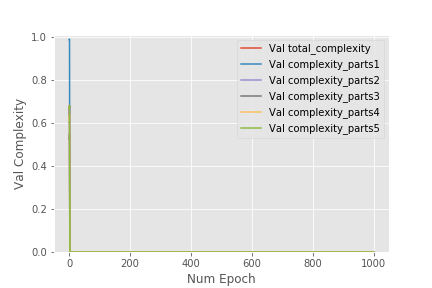

Epoch 1 of 1000 took 370.530s
Epoch 2 of 1000 took 371.405s
Epoch 3 of 1000 took 371.763s


In [ ]:
learn(buldozer,
      X_y,
      watches=['obj', 'recall', 'precision', 'accuracy', 'loss', 'sub_loss', 'total_complexity', 'complexity_parts'],
      num_epochs=1000, batch_size=100
)

In [78]:
buldozer.evaluate(X_y[1][:100], X_y[-1][:100])

{'accuracy': array(0.7466666666666667),
 'complexity_parts': array([ 0.81067604,  0.88519329,  0.95099533,  0.98051375,  0.98970979,
         0.77277368], dtype=float32),
 'loss': array(1.755381464958191, dtype=float32),
 'obj': array(2.696818772385433),
 'precision': array(0.2818181812763214),
 'recall': array(0.29807692766189575, dtype=float32),
 'sub_loss': array(0.9405480623245239, dtype=float32),
 'total_complexity': array(0.8892450604812752)}